In [ ]:
pip install konlpy

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 런타임 다시시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
import re
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from konlpy.tag import Okt
from konlpy.tag import Kkma
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# from konlpy.tag import Komoran
# from konlpy.tag import Hannanum

In [ ]:
education = pd.read_csv("교육청민원.csv")
traffic = pd.read_csv("국토교통부민원.csv")
sea = pd.read_csv("해양수산부민원.csv")

In [ ]:
education = education[:3000]
traffic = traffic[:3000]
sea = sea[:3000]

In [ ]:
e_complaint = pd.DataFrame(education['qnaTitl'])
t_complaint = pd.DataFrame(traffic['qnaTitl'])
s_complaint = pd.DataFrame(sea['qnaTitl'])

In [ ]:
# 라벨링

e_complaint['label'] = 0
t_complaint['label'] = 1
s_complaint['label'] = 2

In [ ]:
# 합침

df = pd.concat([e_complaint, t_complaint, s_complaint], axis = 0)
df = df.reset_index().drop('index', axis = 1)

In [ ]:
# 정규표현식으로 한글만 남기기

def clean(dataframe):
    return [re.sub(r'[^ 가-힣]', '', c) for c in dataframe]

In [ ]:
df['qnaTitl'] = clean(df['qnaTitl'])

In [ ]:
def token(data):
    data = clean(data)
    kkma = Kkma()
    tokens_list = []
    for i in data:
        for j in kkma.morphs(i):
            if len(j) > 1:
                tokens_list.append(j)
    token_df = pd.DataFrame(tokens_list, columns = ['token'])
    return token_df

# tokens = pd.concat([education_tokens_df, traffic_tokens_df, sea_tokens_df], axis = 0)  # 모든 토큰들 합침

In [ ]:
education_tokens_df = token(e_complaint.iloc[:,0])
traffic_tokens_df = token(t_complaint.iloc[:,0])
sea_tokens_df = token(s_complaint.iloc[:,0])

tokens = pd.concat([education_tokens_df, traffic_tokens_df, sea_tokens_df], axis = 0)  # 모든 토큰들 합침

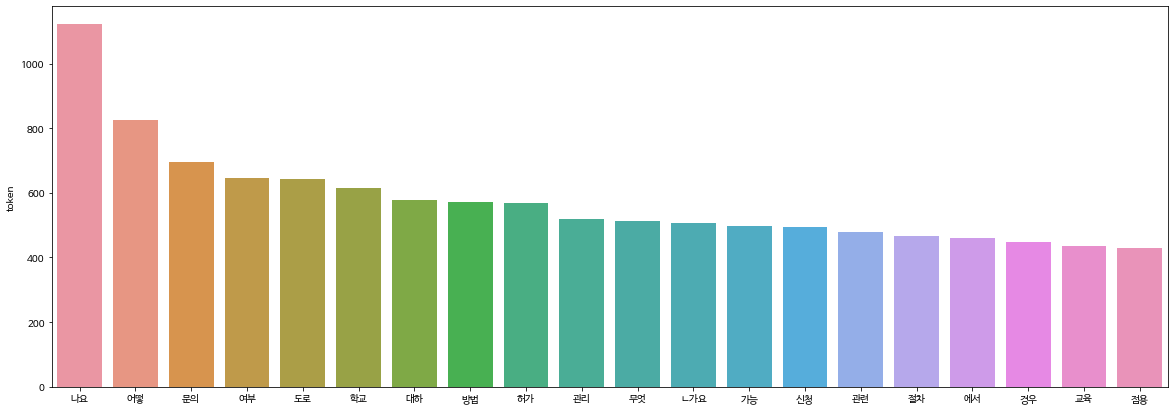

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

fig, ax = plt.subplots(figsize=(20, 7))            
top_10_tokens = tokens['token'].value_counts()
sns.barplot(x=top_10_tokens[0:20].index, y = top_10_tokens[0:20])

plt.show()

In [ ]:
# 불용어 긁어오기

stopwords = []

url = 'https://www.ranks.nl/stopwords/korean'
raw = requests.get(url, verify = False)

soup = BeautifulSoup(raw.text, 'html.parser')

soup = soup.find_all('td')

for i in soup:
    for j in i:
        if j.string == None:
            continue
        else:
            stopwords.append(str(j))

# okt 불용어
stopwords.append('경우')
stopwords.append('인가요')
stopwords.append('되나요')
stopwords.append('있나요')
stopwords.append('하나요')
stopwords.append('하는')
stopwords.append('궁금합니다')

# kkma 불용어
stopwords.append('나요')
stopwords.append('어떻')
stopwords.append('무엇')
stopwords.append('ㄴ가요')
stopwords.append('에서')

stopwords[:5]

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


['아', '휴', '아이구', '아이쿠', '아이고']

In [ ]:
# 여러가지 한국어 처리 함수 만들기
# 한나눔 코모란 너무 오래걸림...

def okt(text):
    okt = Okt()
    text = okt.morphs(text)
    text = clean(text)
    return [c for c in text if len(c) > 1]

def kkma(text):
    kkma = Kkma()
    text = kkma.morphs(text)
    text = clean(text)
    return [c for c in text if len(c) > 1]

# ㅂ니다 같은 걸 빼기 위해 clean함수를 토큰화 함수에 걍 넣음

# def komoran(text):
#     komoran = Komoran()
#     text = komoran.morphs(text)
#     text = clean(text)
#     return [c for c in text if len(c) > 1]

# def hannanum(text):
#     hannanum = Hannanum()
#     text = hannanum.morphs(text)
#     text = clean(text)
#     return [c for c in text if len(c) > 1]

In [ ]:
# 불용어 사전 토큰화함....
# '비걱거리다' --모델 학습--> '비걱거리'

okt_stop = []

for i in stopwords:
    for j in okt(i):
        if len(",".join(okt(j)).split(',')[0]) > 0:
            okt_stop = okt_stop + ",".join(okt(j)).split(',')

okt_stop = list(set(okt_stop))

kkma_stop = []

for i in stopwords:
    for j in kkma(i):
        if len(",".join(kkma(j)).split(',')[0]) > 0:
            kkma_stop = kkma_stop + ",".join(kkma(j)).split(",")

kkma_stop = list(set(kkma_stop))

# hannanum_stop = []
# for i in stopwords:
#     if len(hannanum(i)) > 0:
#         hannanum_stop = hannanum_stop + ",".join(hannanum(i)).split(',')

# hannanum_stop = list(set(hannanum_stop))

# komoran_stop = []
# for i in stopwords:
#     if len(komoran(i)) > 0:
#         komoran_stop = komoran_stop + ",".join(komoran(i)).split(',')

# komoran_stop = list(set(komoran_stop))

In [ ]:
X = df['qnaTitl']
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1, stratify=y) 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [ ]:
tfidf = TfidfVectorizer(lowercase=False)

param_grid = [{'vect__ngram_range': [(1, 1)],
                'vect__stop_words': [okt_stop, None],
                'vect__tokenizer': [okt],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [0.1, 1.0]},
               {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [kkma_stop, None],
              'vect__tokenizer': [kkma],
               'clf__penalty': ['l1', 'l2'],
              'clf__C': [0.1, 1.0]}
               ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(solver = 'liblinear', random_state = 42, multi_class='auto'))])


gs_lr_tfidf = GridSearchCV(lr_tfidf,
                           param_grid,
                           scoring='accuracy',
                           cv = 5,
                           refit = True,
                           verbose = 2)

In [ ]:
gs_lr_tfidf.fit(X_train, y_train)   

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END clf__C=0.1, clf__penalty=l1, vect__ngram_range=(1, 1), vect__stop_words=['대해', '바꿔', '어떤것', '전후', '비걱', '안된다', '하면서', '않는다면', '한적', '부류', '따라', '게우다', '기타', '어찌', '붕붕', '같다', '기대', '봐라', '응당', '하는것이', '않다면', '잠시', '그치지', '하는', '누구', '끼익', '의지', '매번', '아래', '고려', '휘익', '그렇지만', '하여금', '로부터', '리하', '아울러', '않으면', '한마디', '할것도', '일곱', '좋다', '아니', '언제', '일반', '가요', '되다', '이용', '으로', '이천육', '미치다', '년도', '마음대로', '없고', '이유', '만일', '하여야', '하도록', '심지어', '오호', '어째서', '하고있었다', '그래', '하지만', '그렇게', '기점', '각종', '든지', '비로소', '마자', '바꾸어말하면', '그런데', '제각기', '혼자', '허걱', '물론', '습니다', '여섯', '할지언정', '누가', '운운', '삐걱', '얼마간', '좍좍', '와아', '이러한', '제외', '주룩주룩', '인가요', '마치', '으로써', '어쨋', '마저도', '더구나', '즉시', '에야', '버금', '이다', '이외', '인하여', '하나요', '인젠', '더불어', '전부', '시키다', '남짓', '다수', '만하', '알다', '하마터면', '하여', '하도다', '대하', '당장', '꽈당', '오로지', '헉헉', '나머지', '전자', '생각', '해서는', '즈음', '아이쿠', '에게', '하기에', '무슨', '다음', '그런', '우선', '펄렁', '좋아', '소생', '항목', '당신'

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             param_grid=[{'clf__C': [0.1, 1.0], 'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [['대해', '바꿔', '어떤것', '전후', '비걱',
                                                '안된다', '하면서', '않는다면', '한적',
                                                '부류', '따라', '게우다', '기타', '어찌',
                                                '붕붕', '같다', '기대',...
                          'vect__tokenizer': [<function okt at 0x7f0cb66e18c0>]},
                         {'clf__C': [0.1, 1.0], 'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)

In [ ]:
print('최적의 매개변수 조합: %s ' % gs_lr_tfidf.best_params_)    # 대체 왜인지 불용어 사전이 없는 게 베스트 파라미터... 불용어 사전이 완벽하지 않았기 때문인 걸로 추측됨
print('CV 정확도: %.3f' % gs_lr_tfidf.best_score_)

최적의 매개변수 조합: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function kkma at 0x7f0c9606acb0>} 
CV 정확도: 0.913


In [ ]:
clf = gs_lr_tfidf.best_estimator_
print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.911


In [ ]:
y_pred = clf.predict(X_test)
y_true = y_test

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

array([[849,  31,  20],
       [ 59, 790,  51],
       [ 30,  48, 822]])

In [ ]:
# from sklearn.metrics import plot_confusion_matrix

# plot_confusion_matrix(gs_lr_tfidf, X_test, y_test)
# plot_confusion_matrix가 사라져서 밑의 ConfusionMatrixDisplay를 사용

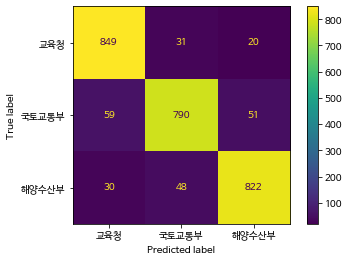

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred),
                              display_labels=['교육청', '국토교통부', '해양수산부'])

disp.plot()
plt.show()

# 첫 행은 원래는 교육청건데 31개를 국토교통부로 분류하고 20개는 해양수산부로 분류함
# 두 번째 행은 원래는 국토교통부건데 59개를 교육청으로, 51개를 해양수산부로 분류함
# 세 번째 행은 원래는 해양수산부건데 30개를 교육청으로, 48개를 국토교통부로 분류함

In [ ]:
print('마이크로 정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='micro'))    # 정확도 구하는 공식을 그냥 분모에 모두 더하고 분자에 모두 더하는 거
print('마크로 정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='macro'))    

마이크로 정밀도: 0.911
마크로 정밀도: 0.912


In [ ]:
print('마이크로 재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='micro'))
print('마크로 재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='macro'))

마이크로 재현율: 0.911
마크로 재현율: 0.911


In [ ]:
print('마이크로 평균 F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='micro'))
print('마크로 평균 F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='macro'))

마이크로 평균 F1: 0.911
마크로 평균 F1: 0.911


In [ ]:
clf.predict(['히터가 고장나서 교실이 너무 추워요'])   # 교육청으로 분류됨

array([0])

In [ ]:
clf.predict_proba(['히터가 고장나서 교실이 너무 추워요'])    # 교육청으로 분류될 확률이 약 50% 정도(다 합치면 1이 나옴)

[[0.49881528 0.21958658 0.28159814]]


In [ ]:
clf.predict(['부실공사로 인해 아파트가 흔들립니다.'])      # 국토교통부로 분류됨

array([1])

In [ ]:
clf.predict_proba(['부실공사로 인해 아파트가 흔들립니다.'])    # 국토교통부로 분류될 확률이 약 59% 정도

array([[0.1113491 , 0.58544919, 0.30320171]])

In [ ]:
clf.predict(['어업 쓰레기 무단 투기'])      # 해양수산부로 분류됨

array([2])

In [ ]:
clf.predict_proba(['어업 쓰레기 무단 투기'])    # 해양수산부로 분류될 확률이 약 86% 정도

array([[0.08231028, 0.05401378, 0.86367594]])